# Code to pull terminus positions from the manual delineations exported from GEEDiT

_By Jukes Liu. last modified 11-10-2019._

## Set up:

In [196]:
import pandas as pd
import numpy as np
import os
import subprocess
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import matplotlib.pylab as pl
import numpy.ma as ma
import datetime
import math
from PIL import Image
import scipy.misc

import shutil

#geospatial packages
import fiona
import geopandas as gpd
from shapely.geometry import Polygon, Point, LineString
import shapely
#shapely to explore 2D spatial relationships (e.g. intersection of 2 vector files)

basepath = '/media/jukes/jukes1/Manual/EarthEngine/'

In [197]:
#Read in glacier velocity data
flowspeed_df= pd.read_csv('/home/jukes/Documents/Sample_glaciers/Glacier_velocities.csv', sep=',', dtype=str, header=0, usecols=[1,2,3])
flowspeed_df = flowspeed_df.set_index('BoxID')

In [198]:
#define a function to help us find the intersection of a line and a collection of points:
#determines if an input value is within a certain range/interval or a setvalue:
def within(value, setval, interval):
    if value >= setval-interval and value <= setval+interval:
        return True
    else:
        return False

In [199]:
def distance(x1, y1, x2, y2):
    dist = math.sqrt(((x2-x1)**2)+((y2-y1)**2))
    return dist

## 1) Reproject manual delineation shapefiles into Greenland Polar Stereo and grab BoxIDs

For different versions of delineations of the same image, pick the most recent one (2) instead of (1) or the original.

In [3]:
# counter = 0
# taggedimgs = []
# tagged2 = []
# BoxIDs = []

# for file in os.listdir(basepath):
#     if '(' in file and file not in taggedimgs:
#         taggedimgs.append(file.split('(')[0])

# for file in os.listdir(basepath):
#     for img in taggedimgs: 
#         if file.startswith(img) and '(' not in file:
#             #remove the images without parentheses
#             if file in os.listdir(basepath):
#                 os.remove(basepath+file)
#         if file.startswith(img) and '(2)' in file:
#             tagged2.append(file.split('(')[0])
# tagged2 = set(tagged2)

# for file in os.listdir(basepath):
#     for img in tagged2: 
#         if file.startswith(img) and '(1)' in file:
#             os.remove(basepath+file)
#             print(file)

Reproject into Greenland Polar Stereo:

In [202]:
counter = 0
BoxIDs = []

for folder in os.listdir(basepath):
    BoxIDs.append(folder[3:])
    
    for file in os.listdir(basepath+folder):
        if file.endswith('.shp'):
#             #pull BoxID from name of file
#             BoxID = '%03d' % int(file.split('_')[0][3:])

            #reproject the file from lat, long to Greenland Polar Stereo
            linepath = basepath+folder+'/'+file[:-4]
            rp_command = 'ogr2ogr -f "ESRI Shapefile" -t_srs EPSG:3413 -s_srs EPSG:4326 '+linepath+'_PS.shp '+linepath+'.shp'
#             print(rp_command)
            subprocess.call(rp_command, shell=True)

            #keep track of how many shapefiles there are
            counter = counter + 1
        
print(counter)
BoxIDs = list(set(BoxIDs))
print(BoxIDs)

1610
['002', '001', '259', '120', '174']


Split into their own box folders:

In [8]:
# #make results directory in BoxID folder if it doesn't already exist
# for BoxID in BoxIDs:
#     if os.path.exists(basepath+"Box"+BoxID):
#         print("Already exists.")
#         #OTHERWISE, create the folder and download into it
#     else:
#         os.mkdir(basepath+"Box"+BoxID)
#         print("Folder made for Box"+BoxID)

In [7]:
# #move em!
# for BoxID in BoxIDs:
#     box = '%01d' % int(BoxID)
#     for file in os.listdir(basepath):
#         if file.startswith('Box'+box) and len(file)>6:
#             shutil.move(basepath+file, basepath+'Box'+BoxID+'/'+file)
#             print(file+' moved')

## 2) Rasterize the shapefiles and subset to the buffer zones

In [203]:
for folder in os.listdir(basepath):
    BoxID = folder[3:]
    for file in os.listdir(basepath+folder):
#       print(file)
        if file.endswith('PS.shp'):
            linepath = basepath+folder+'/'+file[:-4]
            rasterize_cmd = 'gdal_rasterize -burn 1.0 -tr 15.0 15.0 -a_nodata 0.0 '+linepath+'.shp '+linepath+'.TIF'
#             print(rasterize_cmd)
            
            subprocess.call(rasterize_cmd, shell=True)

In [204]:
for folder in os.listdir(basepath):
    BoxID = folder[3:]
    for file in os.listdir(basepath+folder):
#       print(file)
        if file.endswith('PS.shp'):
            linepath = basepath+folder+'/'+file[:-4]
            buffer_path = "/home/jukes/Documents/Sample_glaciers/Box"+BoxID+"/Buffer"+BoxID+".shp"
            
            subsetbuffer_cmd = 'gdalwarp -cutline '+buffer_path+' -crop_to_cutline '+linepath+'.TIF'+" "+linepath+'_cut.TIF'
#             print(subsetbuffer_cmd)
            subprocess.call(subsetbuffer_cmd, shell=True)
    
            #ADD SOMETHING TO CONVERT TO PNG

## 3) Rotate the rasterized & subset delineations

Convert images to png files

In [207]:
%%bash

cd /media/jukes/jukes1/Manual/EarthEngine/Box174/
mogrify -format png *cut.TIF

mogrify-im6.q16: Unknown field with tag 33550 (0x830e) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/912.
mogrify-im6.q16: Unknown field with tag 33922 (0x8482) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/912.
mogrify-im6.q16: Unknown field with tag 34735 (0x87af) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/912.
mogrify-im6.q16: Unknown field with tag 34736 (0x87b0) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/912.
mogrify-im6.q16: Unknown field with tag 34737 (0x87b1) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/912.
mogrify-im6.q16: Unknown field with tag 42113 (0xa481) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/912.
mogrify-im6.q16: Unknown field with tag 33550 (0x830e) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/912.
mogrify-im6.q16: Unknown field with tag 33922 (0x8482) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/912.
mogrify-im6.q16:

In [20]:
flowspeed_df

,Flow_dir,Max_speed
BoxID,,
001,56.28428268432617,0.043774381279945374
002,155.9872283935547,3.583226442337036
004,-3.483433723449707,0.6230824589729309
033,142.1181640625,0.7716577649116516
120,-77.38639831542969,0.27788856625556946
174,12.677642822265625,0.9145031571388245
235,-145.85076904296875,0.15709678828716278
259,98.99927520751953,3.0749008655548096
277,-65.12018585205078,0.28601959347724915


Make rotated folders and rotate

In [208]:
#make results directory in BoxID folder if it doesn't already exist
for BoxID in BoxIDs:
    if os.path.exists(basepath+"Box"+BoxID+'/rotated/'):
        print("Already exists.")
        #OTHERWISE, create the folder and download into it
    else:
        os.mkdir(basepath+"Box"+BoxID+'/rotated/')
        print("Folder made for Box"+BoxID)

Already exists.
Already exists.
Already exists.
Already exists.
Already exists.


In [222]:
len('JB_Jan2020_Box001_2013-01-01_2014-10-01_PS_cut.png')

50

In [253]:
for folder in os.listdir(basepath):
    BoxID = folder[3:]
    for file in os.listdir(basepath+folder):
#         print(file)
        if file.endswith('PS_cut.png') and len(file) == 50:
            img  = Image.open(basepath+folder+'/'+file)
            #rotate the image by the flow direction from flowspeed_df
            rotated     = img.rotate(-float(flowspeed_df.loc[BoxID, 'Flow_dir']))
            rotated.save(basepath+folder+'/rotated/R_'+file)
#             print(file)
#             print(flowspeed_df.loc['001', 'Flow_dir'])

## 4) Resize all images to minimum image dimensions

Move terminus box rasters to the folder:

In [24]:
for BoxID in BoxIDs:
    pathtotbox = '/home/jukes/Documents/Sample_glaciers/Box'+BoxID+'/rotated_images/final/crop_Box'+BoxID+'_raster_cut.png'
    shutil.copy(pathtotbox, basepath+'Box'+BoxID+'/rotated/R_'+'crop_Box'+BoxID+'_raster_cut.png')

Check image size for all of them and find the minimum:

In [254]:
for BoxID in BoxIDs:
    dimensions_x = []
    dimensions_y = []
    images = os.listdir(basepath+'Box'+BoxID+'/rotated/')
    for image in images:
        img = mpimg.imread(basepath+'Box'+BoxID+'/rotated/'+image)
        dimensions_x.append(img.shape[1])
        dimensions_y.append(img.shape[0])
    
    #find minimum dimensions
    min_y = np.min(dimensions_y)
    min_x = np.min(dimensions_x)
    index_y = dimensions_y.index(min_y)
    index_x = dimensions_x.index(min_x)
          
    if index_x != index_y:
        print('Something is funky with the image dimesions.')
    else:
        crop_y = dimensions_y[index_y]
        crop_x = dimensions_x[index_y]

        #crop each image if the dimensions are larger than the minimum
        for image in images:
            img = mpimg.imread(basepath+'Box'+BoxID+'/rotated/'+image)
            if img.shape[1] > crop_x or img.shape[0] > crop_y:
                #calculate difference, and divide by 2 to get amount of rows to remove by
                diffx_half = (img.shape[1] - crop_x)/2
                diffy_half = (img.shape[0] - crop_y)/2
                
#                 print(diffx_half, diffy_half)
                
                #if the difference is a half pixel, make sure to remove the full value from the first side only
                if int(diffx_half) != diffx_half:
                    #remember for image slicing y is the first dimension, x is the second
                    img_cropx = img[:, int(diffx_half):-int(diffx_half)-1]
                #otherwise remove it from both sides:
                else:
                    img_cropx = img[:, int(diffx_half):-int(diffx_half)]
                
                #same for y
                if int(diffy_half) != diffy_half:   
                    img_cropy = img_cropx[int(diffy_half):-int(diffy_half)-1, :]
                #otherwise remove it from both sides:
                else:
                    img_cropy = img_cropx[int(diffy_half):-int(diffy_half), :]
                
#                 print(BoxID, crop_y, crop_x)
#                 print(BoxID, img_cropy.shape)
                    
                #save over rotated images with new cropped dimensions:
                scipy.misc.imsave(basepath+'Box'+BoxID+'/rotated/'+image, img_cropy)

/home/jukes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


## 5) Read in rotated and resized boxes to calculate midpoints and centerline

In [225]:
#create dictionary to store each terminus box ndarray by BoxID
termboxes = {}

#read in the terminus box rasters
for BoxID in BoxIDs:
    #load in the raster
    boxpath = basepath+'Box'+BoxID+'/rotated/R_'+'crop_Box'+BoxID+'_raster_cut.png'
#     boxpath = "/media/jukes/jukes1/LS8aws/Box"+BoxID+"/resized/crop_R_Box"+BoxID+"_cut.pgm"
    #read the raster into an ndarray
#     termbox = mpimg.imread(boxpath)
    termbox = cv2.imread(boxpath)
    
#     plt.imshow(termbox)
    termboxes.update({BoxID: termbox})
    print(termbox.shape)

(1161, 1222, 3)
(320, 306, 3)
(991, 758, 3)
(302, 295, 3)
(647, 655, 3)


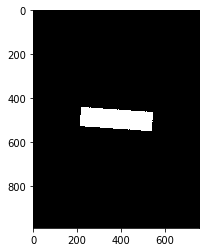

In [226]:
#visualize each terminus box raster by BoxID
termplot = plt.imshow(termboxes['259'])
plt.show()

In [227]:
#create dictionary to store the all coordinates of the box rasters
boxes_xcoords = {}
boxes_ycoords = {}

#create dictionaries for the box vertices
topleft_coords = {}
bottomleft_coords = {}
topright_coords = {}
bottomright_coords = {}

#create dictionaries to store the left midpoints (1C) and right midpoints (2C)
midpoints_x = {}
midpoints_y = {}
midpoints_r_x = {}
midpoints_r_y = {}

#create dictionaries to the slopes and intercepts of the centerline equations
slopes = {}
intercepts = {}

#for all the box rasters
for BoxID in BoxIDs:
    #Read in the raster of the BoxID of interest
    BOI = termboxes[BoxID]
    
    #find the coordinates of where the pixel value is nonzero (where the box exists)
    yindices, xindices, rgb = np.where(BOI > 0)

    #add box coordinates to the dictionary
    boxes_ycoords.update( {BoxID: yindices})
    boxes_xcoords.update( {BoxID: xindices})
    
    
    #1A) FIND THE TOP LEFT COORDINATES (lowest x*y)
    xy = xindices*yindices
    #Find the lowest xy value
    min_xy = np.min(xy)
    #Find the x and y pair corresponding to that xy using the index
    min_xy_i = np.where(xy == min_xy)[0][0]
    topleft = [xindices[min_xy_i], yindices[min_xy_i]]
#     print("Top left", topleft)
    #Add to dictionary of topleft coordinates
    topleft_coords.update(  {BoxID: topleft}  )
    
    #2B) FIND THE BOTTOM RIGHT COORDINATES (highest x*y)
    max_xy = np.max(xy)
    max_xy_i = np.where(xy == max_xy)[0][0]
    bottomright = [xindices[max_xy_i], yindices[max_xy_i]]
    bottomright_coords.update( {BoxID: bottomright})

    #1B) FIND THE BOTTOM LEFT COORDINATE(highest y/x)
    y_x = yindices/xindices
    #Find the highest y/x value
    max_y_x = np.max(y_x)
    #Find the x and y pair corresponding to that y/x using the index
    max_y_x_i = np.where(y_x == max_y_x)[0][0]
    bottomleft = [xindices[max_y_x_i], yindices[max_y_x_i]]
#     print("Bottom left", bottomleft)
    #Add to dictionary of bottomleft coordinates
    bottomleft_coords.update( {BoxID: bottomleft}  )
    
    #2A) FIND THE TOP RIGHT COORDINATES (highest x/y)
    x_y = xindices/yindices
    #find highest x/y value:
    max_x_y = np.max(x_y)
    #Find the x, y pair correpsonding to the maximum x/y using the index
    max_x_y_i = np.where(x_y == max_x_y)[0][0]
    topright = [xindices[max_x_y_i], yindices[max_x_y_i]]
    topright_coords.update( {BoxID: topright} )
    
    #1C and 2C) CALCULATE THE MIDPOINTS
    #Left
    midpoint_x = (topleft[0]+bottomleft[0])/2
    midpoint_y = (topleft[1]+bottomleft[1])/2  
    #Right
    midpoint_r_x = (topright[0]+bottomright[0])/2
    midpoint_r_y = (topright[1]+bottomright[1])/2
    
    #midpoint = [midpoint_x, midpoint_y]
    #Add x and y coordinates to dictionaries
    midpoints_x.update( {BoxID: midpoint_x}  )
    midpoints_y.update( {BoxID: midpoint_y}  )
    midpoints_r_x.update( {BoxID: midpoint_r_x})
    midpoints_r_y.update( {BoxID: midpoint_r_y})
    
    #3) CALCULATE CENTERLINE EQUATION
    #slope
    m = (midpoint_r_y - midpoint_y)/(midpoint_r_x - midpoint_x)
    #y-intercept
    b = midpoint_y - (m*midpoint_x)
#     print("y =", m, "x +", b)
    
    #add slope and intercepts to dictionaries
    slopes.update( {BoxID: m})
    intercepts.update( {BoxID: b})

In [228]:
print(midpoint_y, midpoint_r_y)
# midpoint_y

344.5 302.0


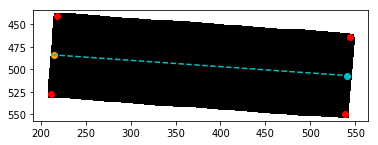

In [229]:
#Choose which glacier BoxID to check:
BOI_ID = '259'

#plot the raster pixels in black
plt.scatter(boxes_xcoords[BOI_ID], boxes_ycoords[BOI_ID], c='k',marker='s')

#plot the vertices in red
plt.scatter(topleft_coords[BOI_ID][0], topleft_coords[BOI_ID][1], c='r')
plt.scatter(bottomleft_coords[BOI_ID][0], bottomleft_coords[BOI_ID][1], c='r')
plt.scatter(topright_coords[BOI_ID][0], topright_coords[BOI_ID][1], c='r')
plt.scatter(bottomright_coords[BOI_ID][0], bottomright_coords[BOI_ID][1], c='r')

#plot midpoints in cyan
plt.scatter(midpoints_x[BOI_ID], midpoints_y[BOI_ID], c='orange')
plt.scatter(midpoints_r_x[BOI_ID], midpoints_r_y[BOI_ID], c='c')

#plot the centerlines in blue
x=np.linspace(np.min(boxes_xcoords[BOI_ID]), np.max(boxes_xcoords[BOI_ID]))
y=slopes[BOI_ID]*x + intercepts[BOI_ID]
plt.plot(x, y, '--c')
         
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.show()

In [230]:
midpoints_x_df = pd.DataFrame.from_dict(midpoints_x, orient='index', columns=["midpoint_x"])
midpoints_y_df = pd.DataFrame.from_dict(midpoints_y, orient='index', columns=['midpoint_y'])
midpoints_rx_df = pd.DataFrame.from_dict(midpoints_r_x, orient='index', columns=["midpoint_rx"])
midpoints_ry_df = pd.DataFrame.from_dict(midpoints_r_y, orient='index', columns=['midpoint_ry'])
cline_slopes_df = pd.DataFrame.from_dict(slopes, orient='index', columns=["cline_slope"])
cline_intercepts_df = pd.DataFrame.from_dict(intercepts, orient='index', columns=["cline_intercept"])

centerline_df = pd.concat([midpoints_x_df, midpoints_y_df, 
                           cline_slopes_df, cline_intercepts_df, midpoints_rx_df, midpoints_ry_df], axis=1)
centerline_df.index.name = 'BoxID'
centerline_df

,midpoint_x,midpoint_y,cline_slope,cline_intercept,midpoint_rx,midpoint_ry
BoxID,,,,,,
002,468.0,575.5,0.033451,559.845070,752.0,585.0
001,117.0,163.5,-0.118881,177.409091,188.5,155.0
259,215.0,484.0,0.070552,468.831288,541.0,507.0
120,111.0,148.5,0.055944,142.290210,182.5,152.5
174,261.5,344.5,-0.323194,429.015209,393.0,302.0


## 6) Read in rasterized delineations and grab pixel coordinates

In [255]:
IDs = []
line_xs = []
line_ys = []
dates = []
for BoxID in BoxIDs:
    for file in os.listdir(basepath+'Box'+BoxID+'/rotated/'):
        if file.startswith('R') and file.endswith('PS_cut.png'):
            #pull date from name of file
            date = file.split('_')[5][:10]
#             print(date)

            linepath = basepath+'Box'+BoxID+'/rotated/'+file
            line = cv2.imread(linepath)
#             print(line.shape)
            
            if len(line.shape) > 2:
#                 print(line)
                y, x, rgb = np.where(line > 0)

                line_x = []
                line_y = []
                for i in range(0, len(y)):
                    x0 = x[i]
                    y0 = y[i]
                    rgb0 = rgb[i]

                    if rgb0 == 0:
#                         print(x0, y0, rgb0)
                        line_x.append(x0)
                        line_y.append(y0)

                IDs.append(BoxID)
                dates.append(date)

                line_xs.append(line_x)
                line_ys.append(line_y)

manual_df = pd.DataFrame(list(zip(IDs, dates, line_xs, line_ys)),
              columns=['BoxID','datetimes', 'Line_x', "Line_y"])
manual_df = manual_df.sort_values(by=['BoxID', 'datetimes'])

In [256]:
manual_df

,BoxID,datetimes,Line_x,Line_y
186,001,2013-05-05,"[135, 134, 135, 133, 133, 132, 134, 134, 135, ...","[140, 141, 141, 142, 143, 144, 145, 146, 146, ..."
269,001,2013-05-14,"[131, 132, 133, 133, 134, 135, 136, 136, 137, ...","[143, 144, 145, 146, 147, 148, 148, 149, 149, ..."
184,001,2013-05-29,"[132, 132, 132, 134, 134, 136, 136, 137, 139, ...","[142, 143, 144, 145, 146, 146, 147, 148, 149, ..."
254,001,2013-08-23,"[133, 132, 133, 131, 132, 131, 130, 131, 131, ...","[141, 142, 142, 143, 143, 144, 145, 146, 147, ..."
266,001,2013-08-27,"[130, 129, 130, 129, 130, 131, 132, 133, 133, ...","[143, 144, 144, 147, 148, 148, 148, 149, 150, ..."
238,001,2013-09-03,"[128, 129, 129, 130, 131, 131, 132, 134, 134, ...","[140, 141, 142, 142, 142, 143, 144, 145, 146, ..."
279,001,2013-09-10,"[131, 132, 130, 131, 129, 130, 129, 129, 130, ...","[139, 140, 141, 141, 142, 142, 143, 145, 146, ..."
203,001,2013-09-17,"[130, 129, 130, 128, 129, 128, 129, 129, 130, ...","[141, 143, 143, 144, 145, 146, 146, 147, 147, ..."
236,001,2013-09-19,"[130, 131, 129, 130, 129, 128, 129, 129, 130, ...","[141, 141, 143, 143, 145, 146, 146, 147, 148, ..."
239,001,2013-09-26,"[129, 128, 129, 128, 129, 130, 130, 131, 132, ...","[143, 145, 145, 146, 146, 146, 147, 148, 148, ..."


## Manual delineations gif Box001

In [268]:
# #Turn datetimes from datetime_df into DateTime objects
# #grab the datetime strings
# datetimes = manual_df.loc[:,'datetimes']
# #create list to store the datetime objects
# datetime_objs = []

# for date in datetimes:
#     date = str(date)
#     datetime_obj = datetime.datetime.strptime(date, '%Y-%m-%d')
#     datetime_obj = np.datetime64(datetime_obj)
#     datetime_objs.append(datetime_obj)

# #add the datetime objects back into the datetime column
# manual_df['datetimes'] = datetime_objs

In [265]:
# manual_df.to_csv(path_or_buf = basepath+"Manual_imgdates.csv", sep=',')

In [267]:
# #PLOT THE LANDSAT IMAGE and TERMINUS BOX
# BoxID = '001'
# box_df = manual_df[manual_df.BoxID == BoxID].copy()
# # box_df = box_df[box_df.Date > np.datetime64('2013-01-01')].copy()

# #Read in the non_rotated subset image:
# # image = mpimg.imread('/media/jukes/jukes1/LS8aws/Box'+BoxID+'/rotated/crop_manual/R_LC80310052014178LGN00_B8_PS_Buffer'+BoxID+'.png')
# tbox = mpimg.imread("/media/jukes/jukes1/LS8aws/Box"+BoxID+"/rotated/crop_manual/Box"+BoxID+"_raster_cut.png")

# plt.figure(figsize=(20,10))
# plt.axis("off")
# imgplt_trim = plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# boxplt = plt.imshow(tbox, alpha=0.1)

# counter = 0
# for idx, row in box_df.iterrows():
#     if idx % 7 == 0:
#         counter = counter + 1
        
# colors = pl.cm.viridis(np.linspace(0,1,counter))

# col_count = 0
# for idx, row in box_df.iterrows():
#     if idx % 7 == 0:
#         #     BoxID = idx
#         line_x = row['Line_x']
#         line_y = row['Line_y']

#         plt.plot(line_x, line_y, color=colors[col_count], linewidth=0.5)
#         col_count = col_count+1
        
# #grab x-values from height of terminus box
# c_slope = float(centerline_df.loc[BoxID]['cline_slope'])
# c_intercept = float(centerline_df.loc[BoxID]['cline_intercept'])
# xmin = float(centerline_df.loc[BoxID]['midpoint_x'])
# xmax = np.max(np.array(list(set(np.nonzero(tbox)[1]))))

# c_x = np.linspace(xmin, xmax, int(xmax-xmin)*2)
# c_y = c_slope*c_x + c_intercept
# plt.plot(c_x, c_y, color='gray')
# plt.plot(c_x[0], c_y[0], 'co')

# plt.show()


## 5) Calculate interesections with centerline and terminus position

In [470]:
intersection_x = []
intersection_y = []
term_pos = []

counter = 0
prev_BoxID = 'anything'

for idx, row in manual_df.iterrows():
#     print(str(row['datetimes'])[:10])
#     if str(row['datetimes'])[:10] == '2014-08-14' and row['BoxID'] == '002':
        line_x = row['Line_x']
        line_y = row['Line_y']
        
        if row['BoxID'] != prev_BoxID:
            #don't duplicate efforts in calculating a new centerline
            BoxID = row['BoxID']

            #grab slope and intercept from the dataframe
            c_slope = float(centerline_df.loc[BoxID]['cline_slope'])
            c_intercept = float(centerline_df.loc[BoxID]['cline_intercept'])

            #grab x-values from height of terminus box
            ymid = float(centerline_df.loc[BoxID]['midpoint_y'])
            xmid = float(centerline_df.loc[BoxID]['midpoint_x'])
            xmax = float(centerline_df.loc[BoxID]['midpoint_rx'])

            c_x = np.linspace(xmid, xmax, int(xmax-xmid)*10)
            c_y = c_slope*c_x + c_intercept

        #FIND Intersections   
        intersect_xs = []
        intersect_ys = []

        #loop through all the x,y values for the centerline
        for j in range(0, len(c_x)):
            x = c_x[j]
            y = c_y[j]
            interval = 1.0
            #where are the intersections with the terminus pick?
            for i in range(0, len(line_x)):
                lx = line_x[i]
                ly = line_y[i]
                if within(lx, x, interval) and within (ly, y, interval):
                    intersect_xs.append(lx)
                    intersect_ys.append(ly)

        if len(intersect_xs) != 0 or len(intersect_ys) != 0:
            intersect_x = np.min(intersect_xs[0])
            intersect_y = intersect_ys[intersect_xs.index(intersect_x)]

#             print(intersect_x, intersect_y)
            intersection_x.append(intersect_x)
            intersection_y.append(intersect_y)

            #calculate terminus position using distance formula
    #         term_position = intersect_y - np.min(c_y)
            term_position = distance(xmid, ymid, intersect_x, intersect_y)

            term_pos.append(term_position*15.0)
        else:
            intersection_x.append(np.nan)
            intersection_y.append(np.nan)
            term_pos.append(np.nan)

            counter = counter + 1
            
        prev_BoxID = BoxID
        
manual_df['intersect_x'] = intersection_x
manual_df['intersect_y'] = intersection_y
manual_df['term_position'] = term_pos

In [471]:
manual_df.to_csv(path_or_buf='/media/jukes/jukes1/Manual/manual_tpos.csv', sep=',')

In [259]:
#Turn datetimes from datetime_df into DateTime objects
#grab the datetime strings
datetimes = manual_df.loc[:,'datetimes']
#create list to store the datetime objects
datetime_objs = []

for date in datetimes:
    date = str(date)
    datetime_obj = datetime.datetime.strptime(date, '%Y-%m-%d')
    datetime_obj = np.datetime64(datetime_obj)
    datetime_objs.append(datetime_obj)

#add the datetime objects back into the datetime column
manual_df['datetimes'] = datetime_objs

## Analyze interanalyst variability:

In [245]:
#Read in duplicate delineations
duplicate_df = pd.read_csv('/media/jukes/jukes1/Manual/LS8_manual_auto_Jan2020_2analysts.csv', usecols=[0,1,2],
                           sep=',')
duplicate_df = duplicate_df.set_index('BoxID')
duplicate_df.head(10)

,Date,Condition
BoxID,,
1,2016-04-18,Sea ice
1,2017-04-03,Sea ice
1,2016-07-07,Clear
1,2016-08-24,Cloudy
1,2016-03-01,Dim
1,2014-09-18,Dim
1,2015-03-31,Cloudy
1,2014-06-09,Sea ice
1,2015-03-10,Clear


In [484]:
differences = []

for idx, row in duplicate_df.iterrows():
    #grab the BoxID and date of duplicate delineation
    BoxID = '%03d' % int(idx)
    date = str(row['Date'])
#     print(len(date))
    if True == True:
#     if date == '2014-08-14':
        df_1 = manual_df[manual_df['BoxID']==BoxID].copy()
    #     print(len(df_1))
        df_2 = df_1[df_1['datetimes']==date].copy()

        #grab the terminus position values from duplicates in manual_df
        diff = abs(np.diff(list(df_2['term_position']))[0])
    #     print(BoxID, date, diff)
        differences.append(diff)

duplicate_df['difference'] = differences

In [474]:
# df_2

In [475]:
# list(df_2['Line_y'])[1]

In [477]:
# BOI = '002'
# plt.plot(list(df_2['Line_x'])[0], list(df_2['Line_y'])[0], 'ro', markersize=2)
# plt.plot(list(df_2['Line_x'])[1], list(df_2['Line_y'])[1], 'yo', markersize=2)

# x= np.linspace(np.min(list(df_2['Line_x'])[0] + list(df_2['Line_x'])[1]), np.max(list(df_2['Line_x'])[0] + list(df_2['Line_x'])[1]))
# y = centerline_df.loc[BOI, 'cline_slope']*x + centerline_df.loc[BOI, 'cline_intercept']

# plt.plot(x, y, '--c')
# plt.show()

In [482]:
# duplicate_df

In [486]:
# np.average(list(duplicate_df['difference']))

print("Max difference: "+str(np.max(list(duplicate_df['difference'])))+' meters')
print("Average difference: "+str(np.average(list(duplicate_df['difference'])))+' meters')

Max difference: 104.95531782434409 meters
Average difference: 19.86513388072691 meters


### Result: inter-analyst variability

- Maximum difference = __~105 meters__ or __7 pixels__
- Average difference = __~20 meters__ or __1.3 pixels__

## 6) Plot manual terminus position time series

In [564]:
BOI = '002'
df = manual_df[manual_df['BoxID']==BOI].copy()
# df

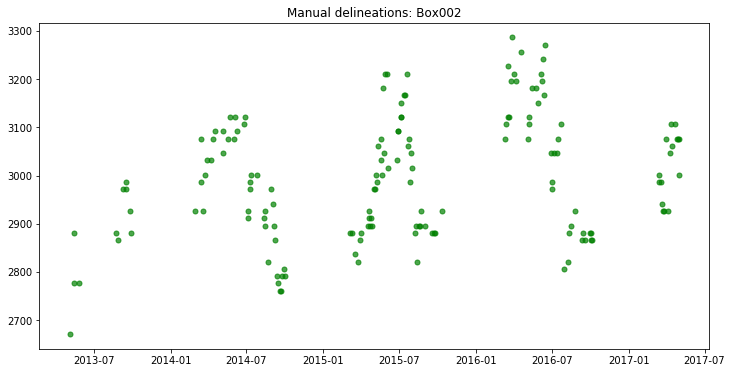

In [565]:
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(df['datetimes'], df['term_position'], 'go', markersize='5', alpha=0.7)
plt.title('Manual delineations: Box'+BOI)
plt.show()

## 7) Plot automated vs. manual time series and analyze difference

In [566]:
#Read in automated df
auto_df = pd.read_csv('/home/jukes/Documents/Sample_glaciers/Tpos_timeseries_Box'+BOI+'_filtered.csv', sep=',')

#Turn datetimes from datetime_df into DateTime objects
#grab the datetime strings
datetimes = auto_df.loc[:,'datetimes']
#create list to store the datetime objects
datetime_objs = []

for date in datetimes:
    date = str(date)
    datetime_obj = datetime.datetime.strptime(date, '%Y-%m-%d')
    datetime_obj = np.datetime64(datetime_obj)
    datetime_objs.append(datetime_obj)

#add the datetime objects back into the datetime column
auto_df['datetimes'] = datetime_objs

In [567]:
# auto_df

In [568]:
#grab max and min dates from automated time series:
maxdate = np.max(list(auto_df['datetimes']))
mindate = np.min(list(auto_df['datetimes']))

#grab only manual delineations between those dates
df_2013 = df[df['datetimes'] > mindate].copy()
ls8_df = df_2013[df_2013['datetimes'] < maxdate].copy()

In [569]:
# df_2013

In [570]:
# ls8_df

In [571]:
# new_tpos = []

# for idx, row in auto_df.iterrows():
#     if row['term_position'] > 400.0:
#         new_tpos.append(np.nan)
#     else:
#         new_tpos.append(row['term_position'])

In [572]:
# auto_df['term_position'] = new_tpos

In [573]:
# #drop nans
# ls8_df = ls8_df.dropna()
# auto_df = auto_df.dropna()

# # #grab max terminus position across both
# max_tpos_man = np.max(list(ls8_df['term_position']))+45#+(2*15.0)
# max_tpos_auto = np.max(list(auto_df['term_position']))
# # max_tpos_man = 0
# # max_tpos_auto = 0
# print(max_tpos_man, max_tpos_auto)

In [574]:
# auto_df

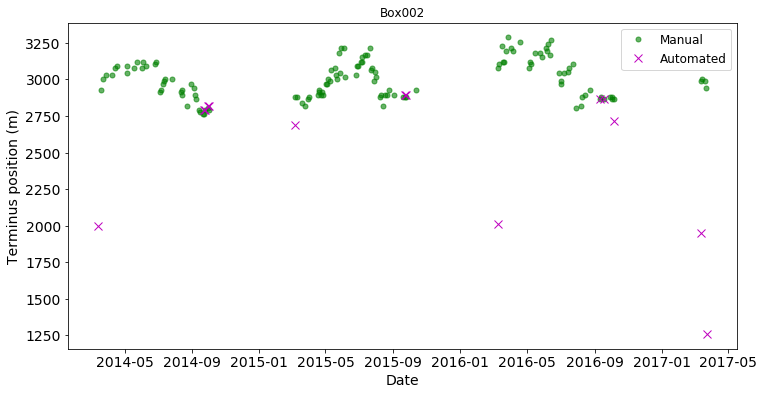

In [575]:
fig, ax1 = plt.subplots(figsize=(12,6))
# ax1.plot(ls8_df['datetimes'], np.array(ls8_df['term_position']) - max_tpos_man, 'go', markersize='5', alpha=0.6)
ax1.plot(ls8_df['datetimes'], np.array(ls8_df['term_position']), 'go', markersize='5', alpha=0.6)
ax1.set_ylabel('Terminus position (m)', color='k', fontsize=14)


#Automated time series
# ax2 = ax1.twinx()
ax1.plot(auto_df['datetimes'], np.array(auto_df['term_position']), 'mx', markersize='8', alpha=1)
# ax1.plot(auto_df['datetimes'], np.array(auto_df['term_position']) - max_tpos_auto, 'mx', markersize='8', alpha=1)
# ax2.set_ylabel('Auto terminus position (m)', color = 'k', fontsize=12)
# ax2.get_yaxis().set_visible(False) 

#GENERAL PLOT PARAMETERS
# ax1.set_title("Box"+BOI, fontsize=16)
ax1.set_xlabel('Date', fontsize=14)
# ax1.set_ylim(-275, 25)
# ax2.set_ylim(-255, 10)
ax1.tick_params(axis='both', which='major', labelsize=14)
# ax2.tick_params(axis='both', which='major', labelsize=12)
fig.legend(['Manual', 'Automated'], bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes, fontsize=12)
# fig.legend(['Manual', 'Automated'], fontsize=12)

#SAVE FIGURE
plt.title("Box"+BOI)
plt.savefig("/media/jukes/jukes1/Manual/Manual_vs_automated_Box"+BOI+".png", dpi=500)
plt.show()

In [576]:
# auto_df

In [577]:
comparison_df = pd.merge(auto_df.drop(['BoxID', 'changerate','Order'], axis=1), ls8_df.drop(['Line_x', 'Line_y', 'BoxID'], axis=1), how='inner', on='datetimes')
comparison_df = comparison_df.dropna()

In [578]:
# #recalculate terminus position for either side
# comparison_df['term_position_x'] = np.array(comparison_df['term_position_x']) - max_tpos_auto
# comparison_df['term_position_y'] = np.array(comparison_df['term_position_y']) - max_tpos_man

In [579]:
comparison_df['auto_man_diff'] = np.array(comparison_df['term_position_x']) - np.array(comparison_df['term_position_y'])

In [580]:
differences = np.array(comparison_df.auto_man_diff)
print("Automated vs. manual delineations")
print(len(comparison_df))
print("Max difference: "+str(np.max(abs(differences)))+' meters')
print("Average difference: "+str(np.average(abs(differences)))+' meters')

Automated vs. manual delineations
12
Max difference: 1066.545343400614 meters
Average difference: 212.71703056830242 meters


In [581]:
93+12+84+37+13

239

In [584]:
(93*61 + 12*212 + 84*15 + 37*28 + 13*401)/239

65.79916317991632

In [586]:
66/15

4.4